---

# II. SEGMENTACIÓN DE TRANSLUCENCIA NUCAL

El objetivo de esta segunda parte del trabajo es lograr entrenar una red neuronal que sea capaz de segmentar de la manera más precisa posible el area anecogénica de la Translucencia Nucal (TN). 
Para ello, se utilizarán las segmentaciones hechas a partir de las bounding boxes del training set original. Este procese se encuentra deetallado en el notebook de anexo `segmentation_from_bb.ipynb`.
A partir de ello, se entrenó un modelo de segmentación semántica basado en la arquitectura U-NET

U-net for the segmentation of NT 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Rescaling
from tensorflow.image import resize
import os 
import cv2

## Pipeline de segmentación del training set

Como se indicó anteriormente, la segmentación propiamente dicha de las imágenes del training set se realizó a partir de las bounding boxes originales. El dataset original no contaba con estas segmentaciones, por lo que se tuvo que diseñar un proceso para extraerlas. La segmentación se realizó de la siguiente manera:

1. Aplicar el denoising anteriormente explicado
2. Aumentar el constraste con CLAHE
3. Aplicar un filtro pasa altos
4. Binarizar la sección de interés de la imagen (interna a la bounding box conocida) por Otsu
5. Aplicar etiquetado sobre las secciones encontradas
6. Seleccionar la etiqueta que corresponde a la TN como aquella con mayor área
7. Tomar el centroide de esta etiqueta 
8. Aplicar region growing a la imágen original partiendo de dicho punto



### Obtener la segmentación de la TN a partir de su bounding box

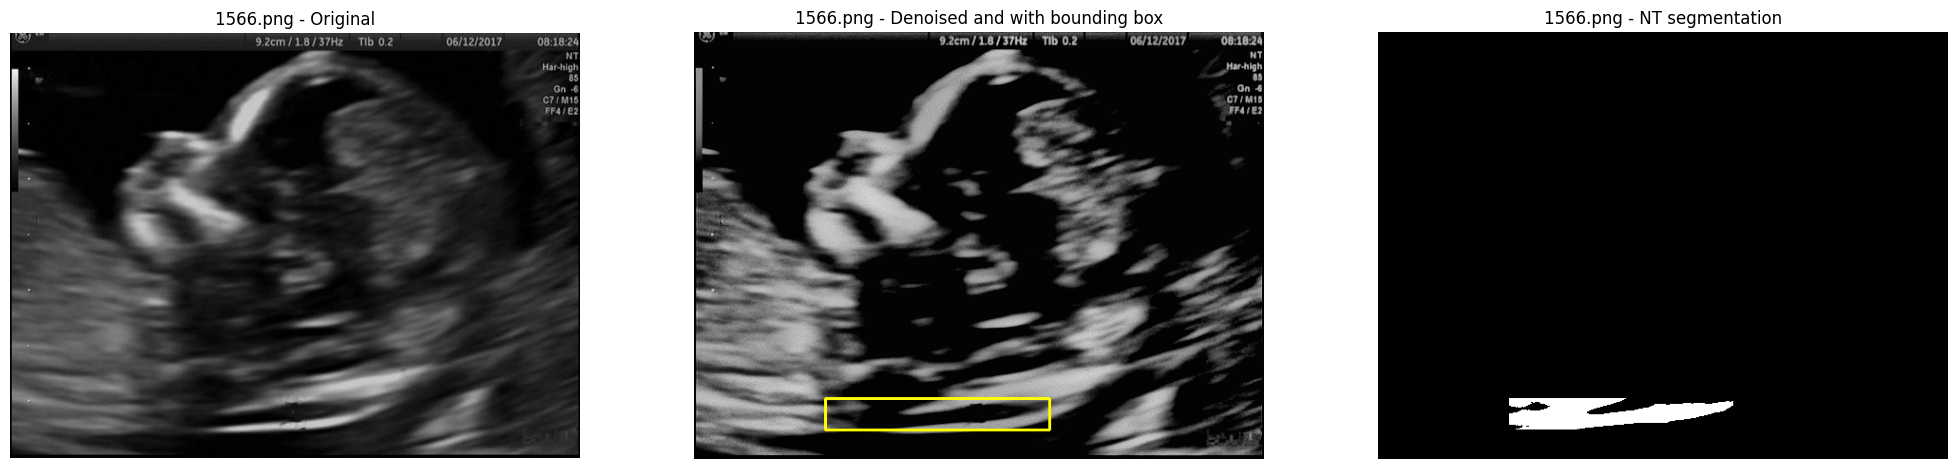

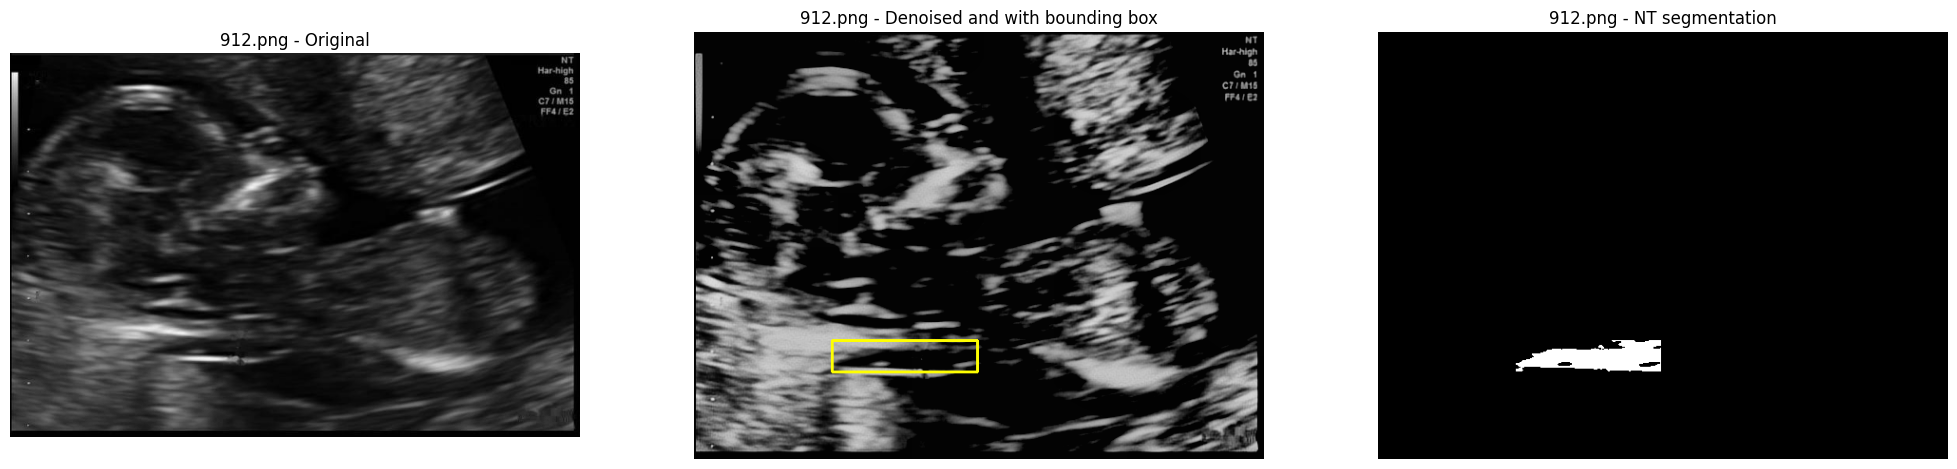

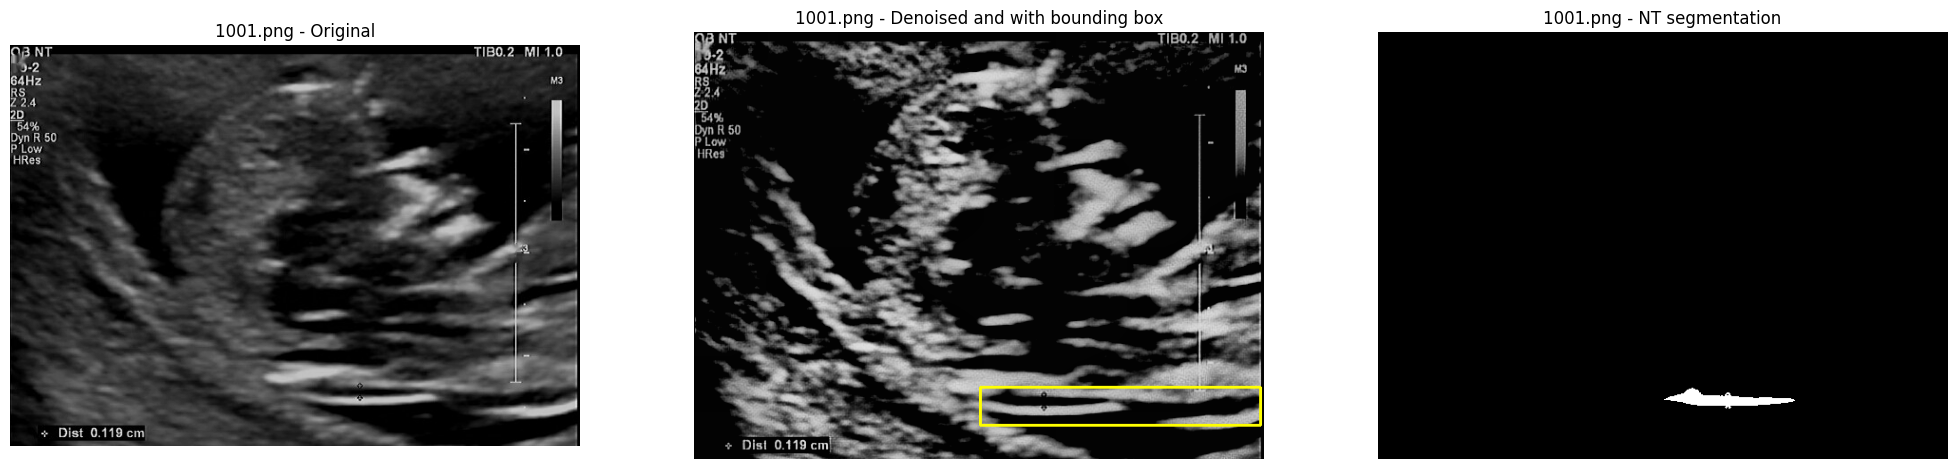

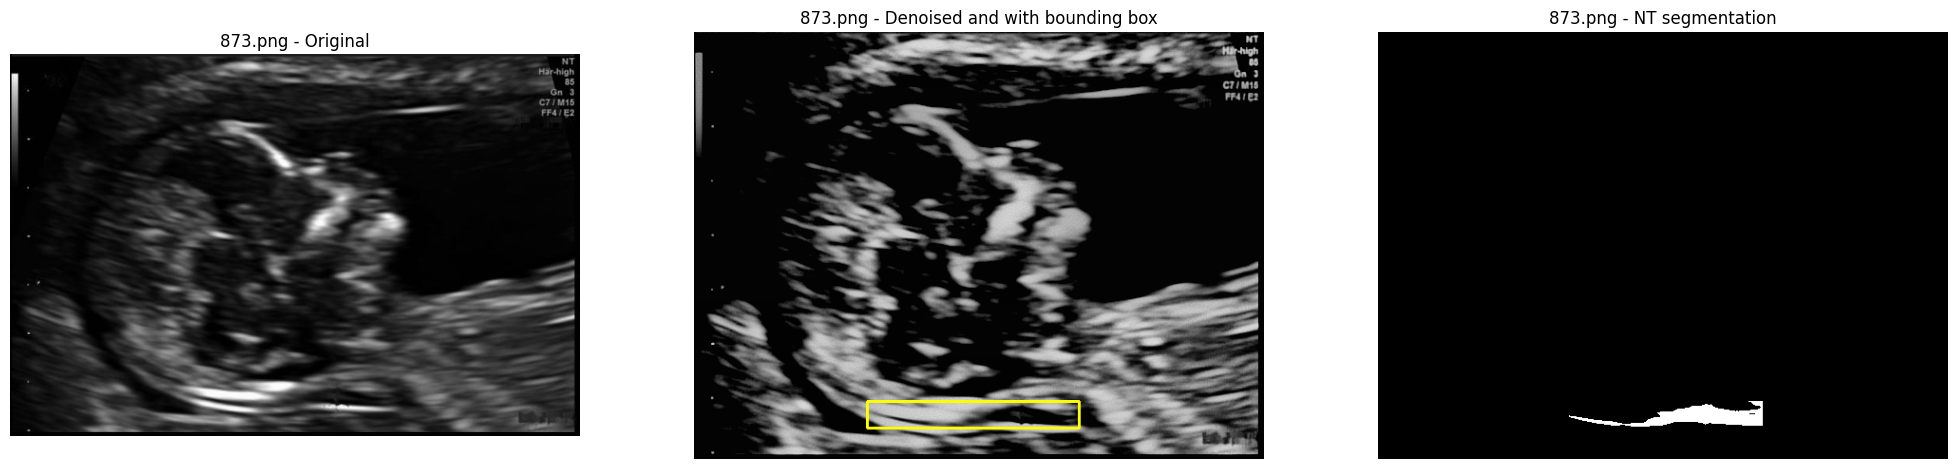

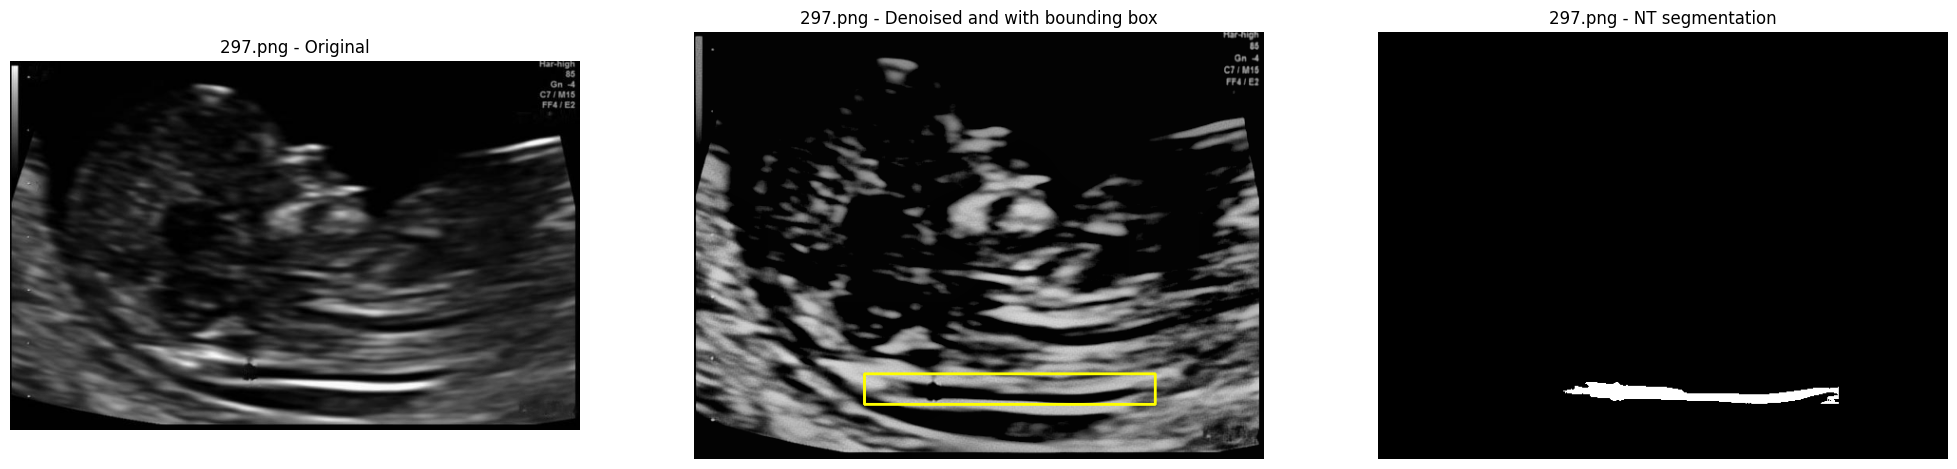

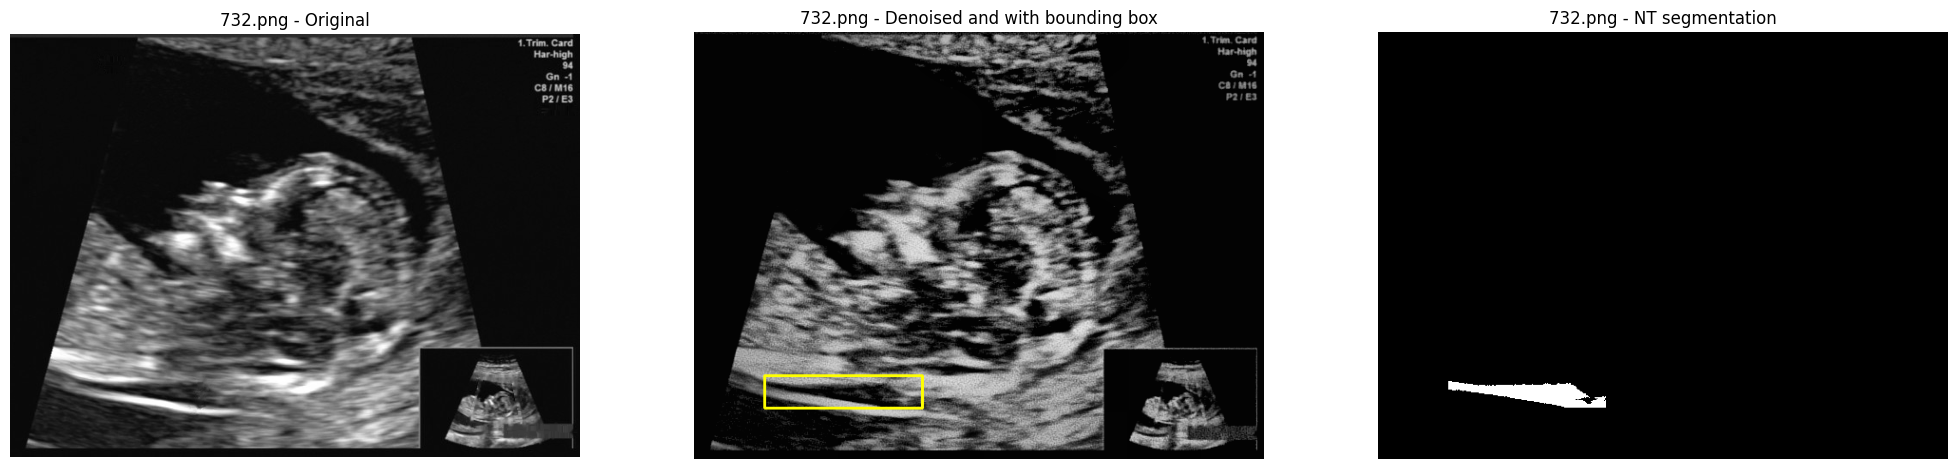

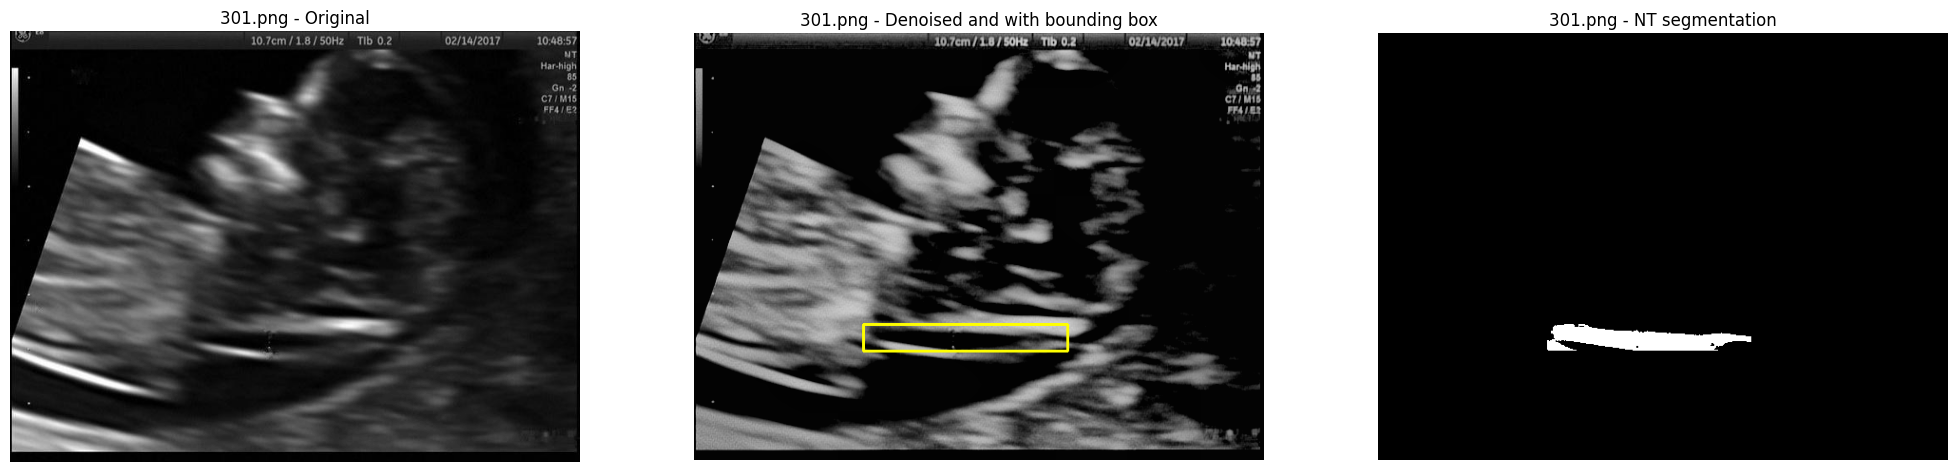

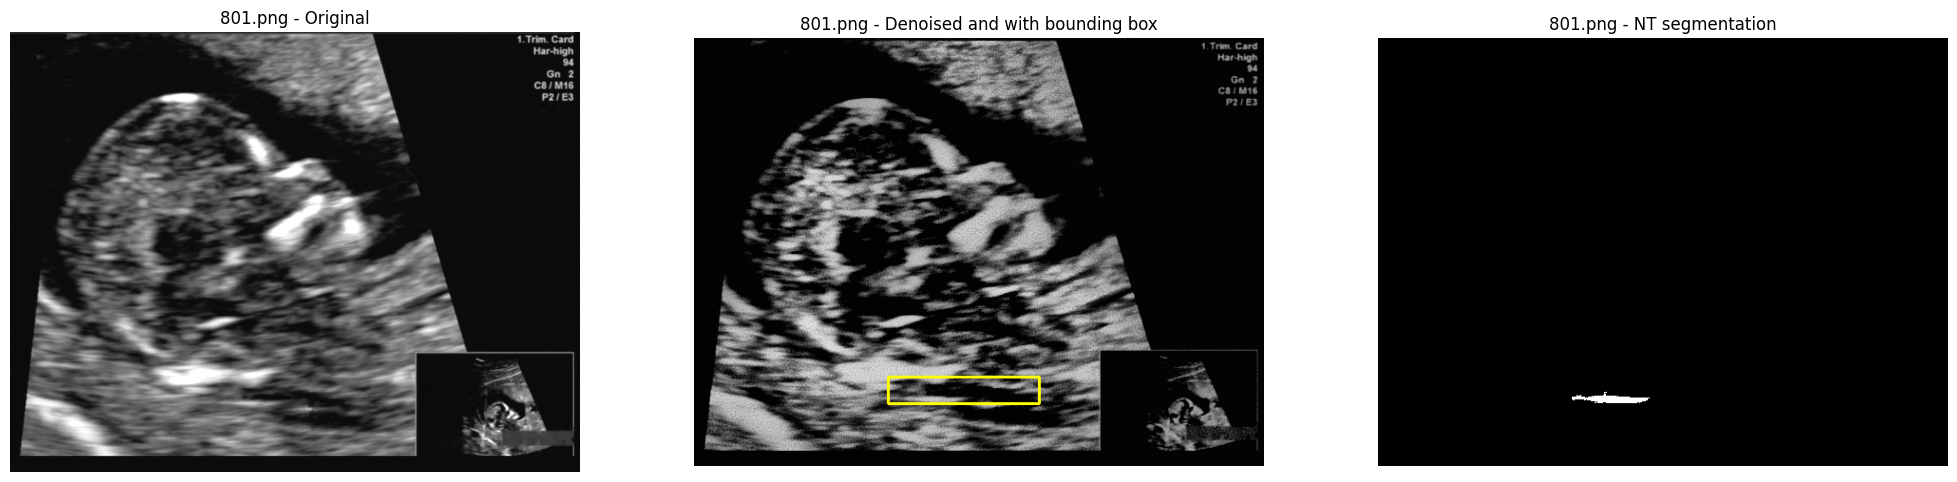

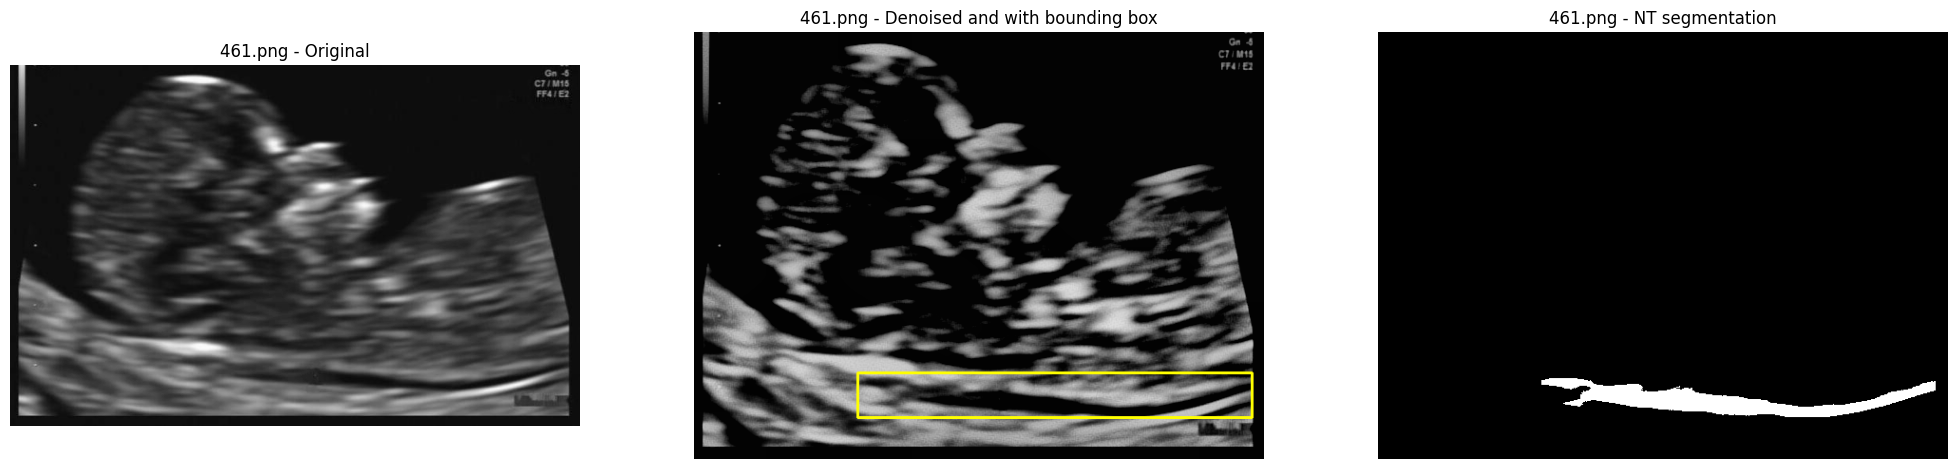

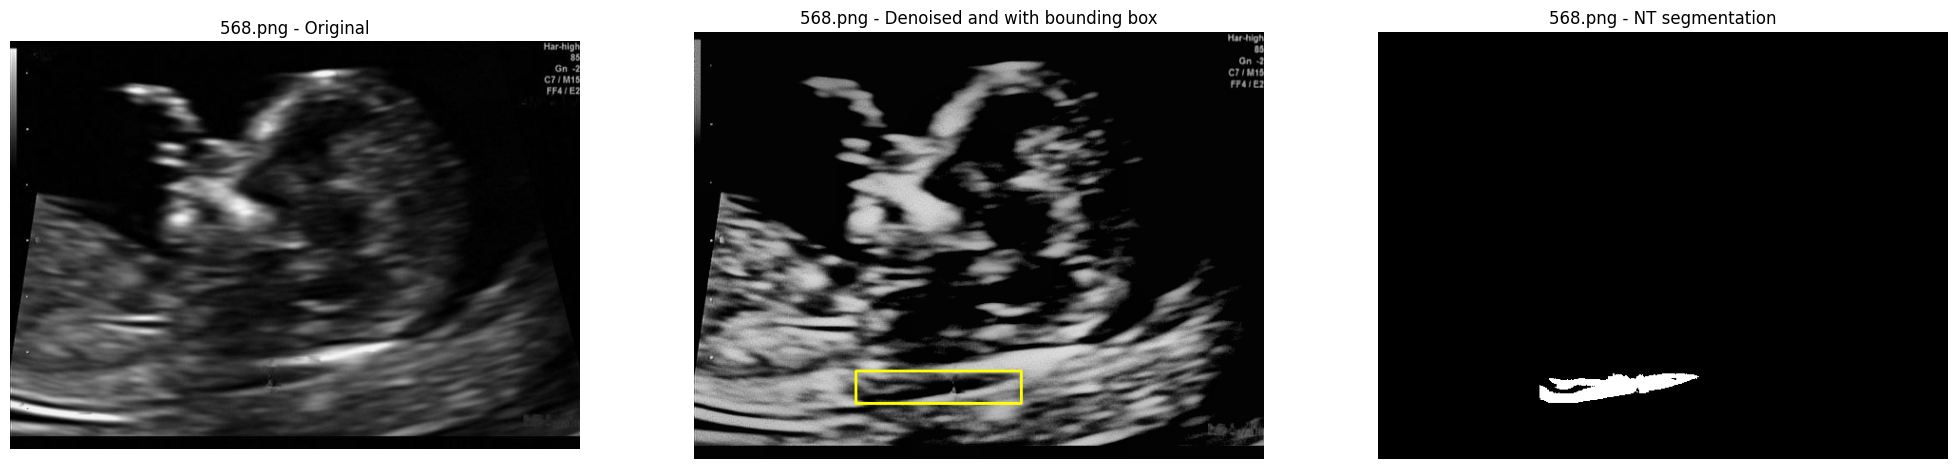

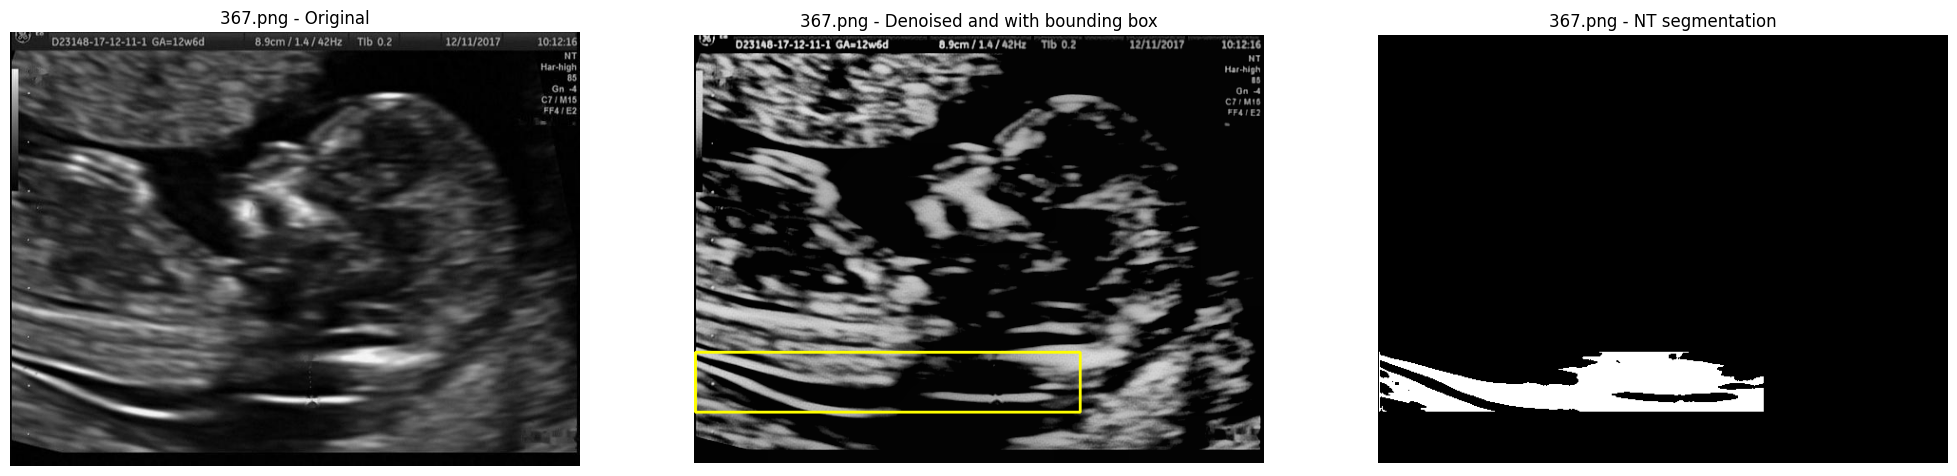

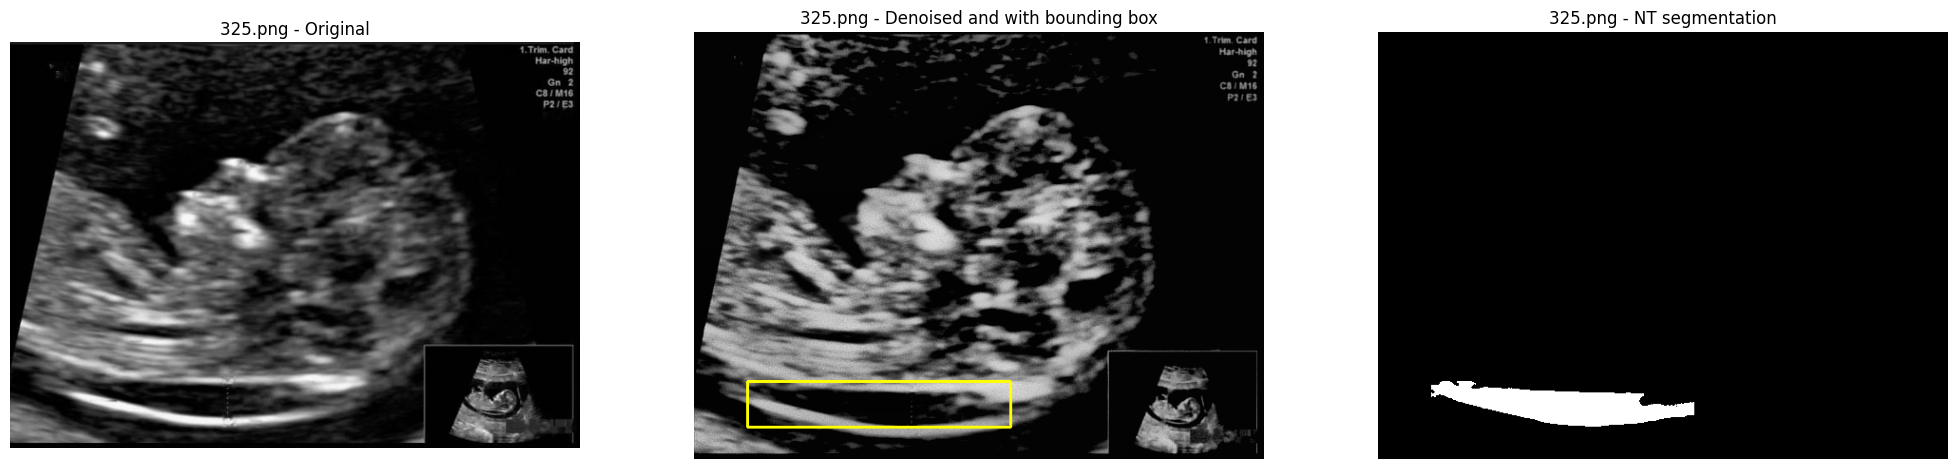

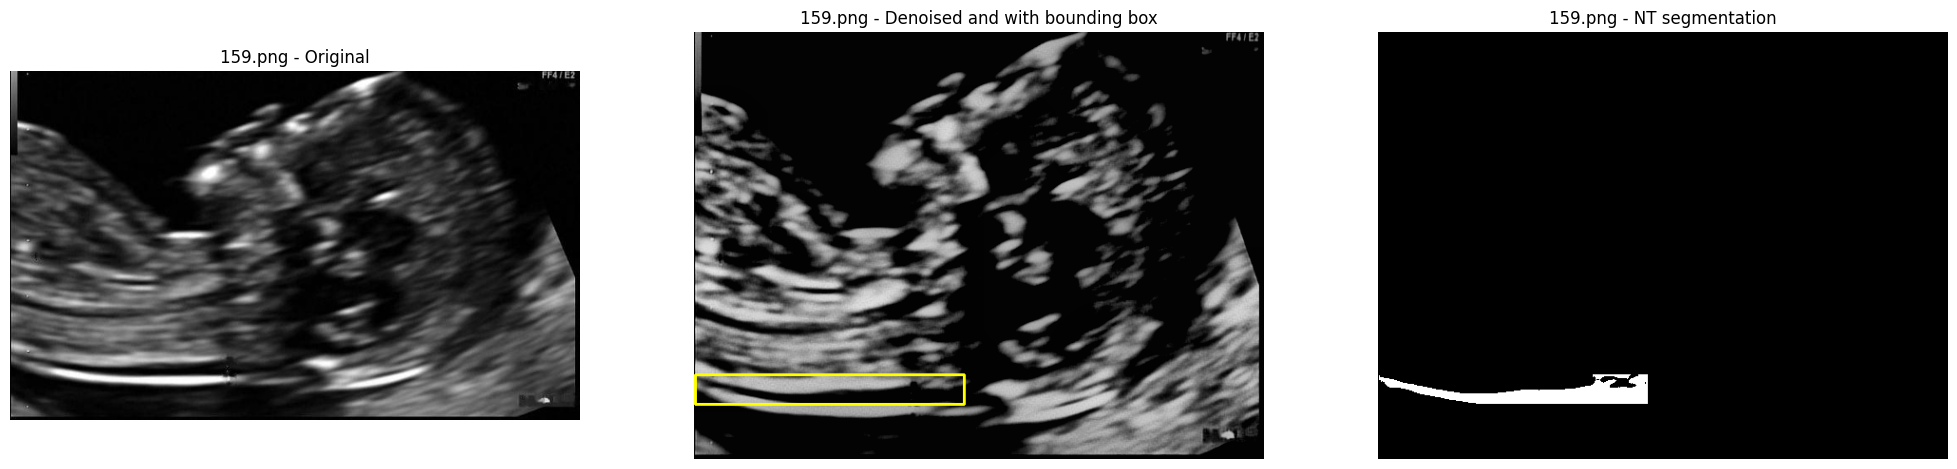

In [67]:
# Gather the images paths
valid_ids = df_nt['fname'].unique()
resize_dim = (600, 450)
images = []
segmentations = []
image_ids = []
bounding_boxes = []

for dataset_standard_path in standard_dirs:
    for i, fname in enumerate(os.listdir(dataset_standard_path)):
        # Skip invalid files
        if not fname.endswith('.png') or fname not in valid_ids:
            continue

        image_ids.append(fname)
        img_raw = cv2.imread(os.path.join(dataset_standard_path, fname), cv2.IMREAD_GRAYSCALE)

        # Resize image
        img = cv2.resize(img_raw, resize_dim)

        # Denoising
        img = lukinoising(img)

        # Equalize histogram to improve contrast using CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img = clahe.apply(img)

        # Convert to color image
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Get the bounding box coordinates
        h_min = df_nt[df_nt['fname'] == fname]['h_min'].values[0]
        h_max = df_nt[df_nt['fname'] == fname]['h_max'].values[0]
        w_min = df_nt[df_nt['fname'] == fname]['w_min'].values[0]
        w_max = df_nt[df_nt['fname'] == fname]['w_max'].values[0]

        # Resize the bounding box
        h_min = int(h_min * img.shape[0] / img_raw.shape[0])
        h_max = int(h_max * img.shape[0] / img_raw.shape[0])
        w_min = int(w_min * img.shape[1] / img_raw.shape[1])
        w_max = int(w_max * img.shape[1] / img_raw.shape[1])

        bounding_boxes.append(np.array([h_min, w_min, h_max, w_max]))

        # High pass sobel filter
        sobel_kernel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) / 8
        img_sobel = cv2.filter2D(img, -1, sobel_kernel)

        # Binarize using otsu
        _, img_otsu = cv2.threshold(img_sobel, 0, 255, cv2.THRESH_OTSU)

        # Apply labeling segmentation
        img_inside_bb = img_otsu[h_min:h_max, w_min:w_max]
        labels, num_features = label(img_inside_bb)
        labels_uint8 = (labels * (255 // num_features)).astype(img.dtype)

        # The most common label contains the NT
        nt_label = np.argmax(np.bincount(labels.flatten())[1:]) + 1
        nt_segmentation = labels == nt_label

        # Pick the centroid of this label as the seed for a flood fill applied to the otsu binarized image
        # NOTE: The flood is applied to the otsu binarized image without high pass filtering
        nt_points = np.argwhere(nt_segmentation)
        centroid = nt_points.mean(axis=0).astype(int)
        x_seed, y_seed = centroid
        _, otsu_no_hp = cv2.threshold(img[h_min:h_max, w_min:w_max], 0, 255, cv2.THRESH_OTSU)
        nt_segmentation = skimage.segmentation.flood(otsu_no_hp, (x_seed, y_seed), tolerance=10)

        # Draw the segmentation as a binary image of the same shape as the original
        segmentation = np.zeros_like(img)
        segmentation[h_min:h_max, w_min:w_max] = nt_segmentation * 255

        # Draw one of every 20 images
        if not i % 100:
            fig, axs = plt.subplots(1, 3, figsize=(25, 10))
            img_rect = cv2.rectangle(img_color.copy(), (w_min, h_min), (w_max, h_max), (255, 255, 0), 2)

            axs[0].imshow(img_raw, cmap='gray')
            axs[0].axis('off')
            axs[0].set_title(f"{fname} - Original")

            axs[1].imshow(img_rect, cmap='gray')
            axs[1].axis('off')
            axs[1].set_title(f"{fname} - Denoised and with bounding box")

            axs[2].imshow(segmentation, cmap='gray')
            axs[2].axis('off')
            axs[2].set_title(f"{fname} - NT segmentation")

            plt.show()

        images.append(img_color)
        segmentations.append(segmentation)

## Lectura del Dataset, preprocesado y segmentado

In [2]:
images_path = '/kaggle/input/fetus-segmentation/preprocessed_images'
masks_path = '/kaggle/input/fetus-segmentation/segmentations'
images = []
masks = []

for file in os.listdir(images_path):
    img_path = os.path.join(images_path,file)
    segmentationfile = f'seg_{file}'
    mask_path = os.path.join(masks_path,segmentationfile)
    images.append(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))
    masks.append(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE))


Las imagenes se convierten a RGB para facilitar el preprocesamiento, debido a las funciones de resize de Tensorflow

In [3]:
for i in range(0,len(images)): 
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_GRAY2RGB)

In [ ]:
images = np.array(images)
masks = np.array(masks)

## Verificación de datos

Verifco que se descargue bien 

In [6]:
images.shape

(1110, 450, 600, 3)

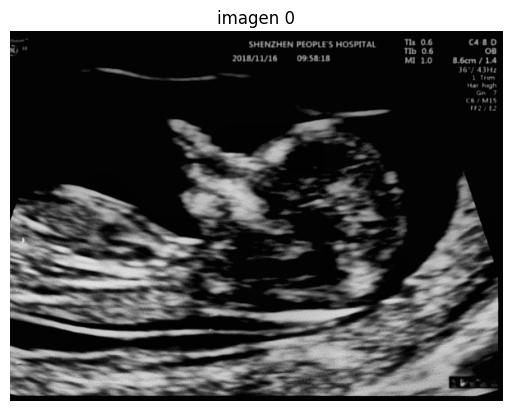

In [7]:
plt.imshow(images[0, :, :, :].astype('uint8'))  # Assuming pixel values are in [0, 255]
plt.title("imagen 0")
plt.axis('off')
plt.show()

In [8]:
masks.shape

(1110, 450, 600)

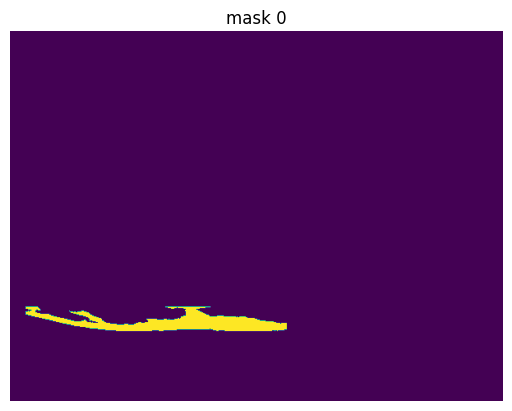

In [9]:
plt.imshow(masks[0, :, :].astype('uint8'))  # Assuming pixel values are in [0, 255]
plt.title("mask 0")
plt.axis('off')
plt.show()

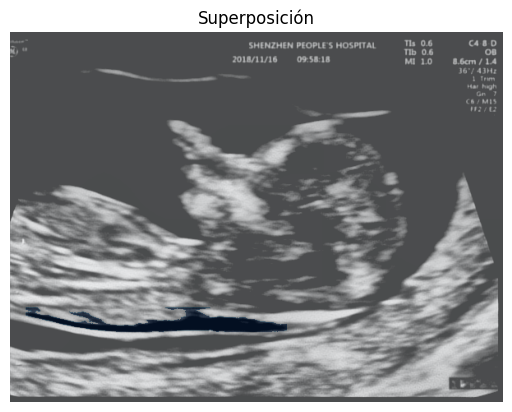

In [10]:
plt.imshow(images[0, :, :, :])
plt.imshow(masks[0, :, :], alpha=0.3, cmap='Blues')
plt.title('Superposición')
plt.axis('off')
plt.show()

## Normalización 

In [11]:
# Checkeo que el valor maximo es 255, de forma rapida
np.max(images[:,:,:,:])

249

In [12]:
np.max(masks[0,:,:])

255

In [13]:
# rescaling layer
rescale_layer = Rescaling(scale=1./255)

def preprocess_images(images, target_size=(225, 300)):
    #para compativilidad con tf
    images = images.astype(np.float32)
    # Resize 
    resized_images = resize(images, target_size)
    # Normalize images
    normalized_images = rescale_layer(resized_images)
    return normalized_images

### Normalización imágenes 

In [14]:
# Process images in batches
batch_size = 100  # Adjust batch size based on your memory capacity
num_batches = len(images) // batch_size + (1 if len(images) % batch_size != 0 else 0)

preprocessed_images = []

for i in range(num_batches):
    start = i * batch_size
    end = start + batch_size
    batch_images = images[start:end]
    
    # Preprocess the batch
    processed_batch = preprocess_images(batch_images)
    
    # Convert the processed batch to a NumPy array and store it
    preprocessed_images.append(processed_batch.numpy())
    
    # Delete the batch to free up memory
    del batch_images, processed_batch
     
    # Delete the processed batch from the original array to free up memory
    images[start:end] = np.zeros_like(images[start:end])  # Set to zeros to free up memory

# Concatenate all processed batches into a single array
preprocessed_images = np.concatenate(preprocessed_images, axis=0)

# Example: Display the shape of the preprocessed images
print(preprocessed_images.shape)

(1110, 225, 300, 3)


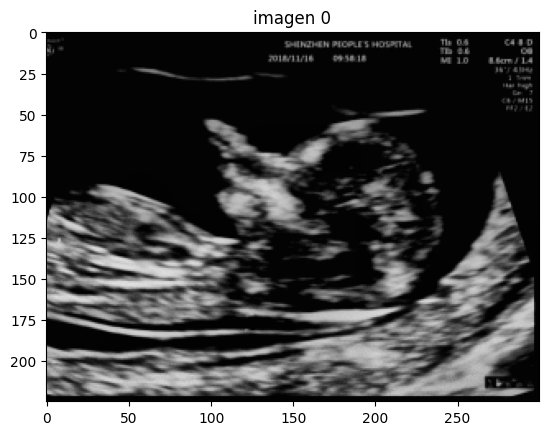

In [15]:
plt.imshow(preprocessed_images[0, :, :, :])
plt.title('imagen 0')
#plt.axis('off')
plt.show()

Verifico que se realizó correctamente la normalización 

In [ ]:
print(f'el valor máximo para la normalización de imágenes es {np.max(preprocessed_images[:, :, :, :])}')
print(f'el valor mánimo para la normalización de imágenes es {np.min(preprocessed_images[:, :, :, :])}')

el valor máximo para la normalización de imágenes es 0.9627451300621033
el valor mánimo para la normalización de imágenes es 0.003921568859368563


### Normalización de Máscaras 

In [18]:
# Function to preprocess masks
def preprocess_masks(masks, target_size=(225, 300)):
    # Convert masks to float32 for TensorFlow compatibility
    masks = masks.astype(np.float32)
    # Resize masks
    resized_masks = resize(masks[..., np.newaxis], target_size)
    # Normalize masks
    normalized_masks = rescale_layer(resized_masks)
    return normalized_masks

In [19]:
# Process masks in batches
batch_size = 100  # Adjust batch size based on your memory capacity
num_batches = len(masks) // batch_size + (1 if len(masks) % batch_size != 0 else 0)

preprocessed_masks = []

for i in range(num_batches):
    start = i * batch_size
    end = start + batch_size
    batch_masks = masks[start:end]
    
    # Preprocess the batch
    processed_batch = preprocess_masks(batch_masks, target_size=(225, 300))
    
    # Convert the processed batch to a NumPy array and store it
    preprocessed_masks.append(processed_batch.numpy())
    
    # Delete the batch to free up memory
    del batch_masks, processed_batch
     
    # Delete the processed batch from the original array to free up memory
    masks[start:end] = np.zeros_like(masks[start:end])  # Set to zeros to free up memory

# Concatenate all processed batches into a single array
preprocessed_masks = np.concatenate(preprocessed_masks, axis=0)

# Example: Display the shape of the preprocessed masks
print(preprocessed_masks.shape)

(1110, 225, 300, 1)


In [ ]:
print(f'el valor máximo para la normalización de máscaras es {np.max(preprocessed_masks[:, :, :, :])}')
print(f'el valor mínimo para la normalización de máscaras es {np.min(preprocessed_masks[:, :, :, :])}')

el valor máximo para la normalización de máscaras es 1.0
el valor mínimo para la normalización de máscaras es 0.0


## Train Test Split 

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(preprocessed_images, preprocessed_masks, test_size=0.1, random_state=42)

# Example: Display the shape of the train and test sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (999, 225, 300, 3)
X_val shape: (111, 225, 300, 3)
y_train shape: (999, 225, 300, 1)
y_val shape: (111, 225, 300, 1)


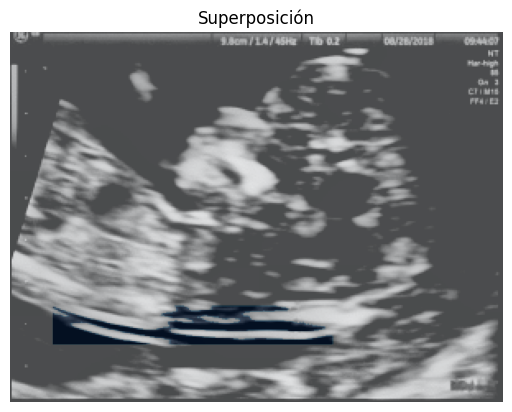

In [25]:
plt.imshow(X_train[0, :, :, :])
plt.imshow(y_train[0, :, :], alpha=0.3, cmap='Blues')
plt.title('Superposición')
plt.axis('off')
plt.show()

##  Diseñar una red tipo U-Net

### Imports modelo

In [26]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow import GradientTape
from tensorflow import argmax
from tensorflow import reduce_mean
from tensorflow import reduce_sum
import tensorflow.keras.backend as K


In [27]:
from tensorflow.keras.layers import ZeroPadding2D

In [28]:
from tensorflow.keras.metrics import BinaryAccuracy

In [29]:
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow import convert_to_tensor


### Arquitectura Modelo 

In [30]:
def encoder_block(inputs, num_filters): 
    # Convolution with 3x3 filter followed by ReLU activation
    x = Conv2D(num_filters, 3, padding='same')(inputs) 
    x = Activation('relu')(x) 

    # Convolution with 3x3 filter followed by ReLU activation
    x = Conv2D(num_filters, 3, padding='same')(x) 
    x = Activation('relu')(x) 

    # Max Pooling with 2x2 filter
    p = MaxPool2D(pool_size=(2, 2))(x) 
    return x, p

In [31]:
def decoder_block(inputs, skip_features, num_filters): 
    # Upsampling with 2x2 filter
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(inputs) 

    # Ensure the shapes match by cropping or padding
    if x.shape[1] != skip_features.shape[1] or x.shape[2] != skip_features.shape[2]:
        x = ZeroPadding2D(((0, skip_features.shape[1] - x.shape[1]), (0, skip_features.shape[2] - x.shape[2])))(x)

    # Concatenate skip connections
    x = Concatenate()([x, skip_features]) 

    # Convolution with 3x3 filter followed by ReLU activation
    x = Conv2D(num_filters, 3, padding='same')(x) 
    x = Activation('relu')(x) 

    # Convolution with 3x3 filter followed by ReLU activation
    x = Conv2D(num_filters, 3, padding='same')(x) 
    x = Activation('relu')(x) 
    return x

In [32]:
def unet_model(input_shape=(225, 300, 3), num_classes=1): 
    inputs = Input(input_shape) 
    
    # Contracting Path
    s1, p1 = encoder_block(inputs, 64) 
    s2, p2 = encoder_block(p1, 128) 
    s3, p3 = encoder_block(p2, 256) 
    s4, p4 = encoder_block(p3, 512) 
    
    # Bottleneck
    b1 = Conv2D(1024, 3, padding='same')(p4) 
    b1 = Activation('relu')(b1) 
    b1 = Conv2D(1024, 3, padding='same')(b1) 
    b1 = Activation('relu')(b1) 
    
    # Expansive Path
    d1 = decoder_block(b1, s4, 512) 
    d2 = decoder_block(d1, s3, 256) 
    d3 = decoder_block(d2, s2, 128) 
    d4 = decoder_block(d3, s1, 64) 
    
    # Output Layer
    outputs = Conv2D(num_classes, 1, activation='sigmoid' if num_classes == 1 else 'softmax')(d4) 
    
    model = Model(inputs, outputs, name='U-Net') 
    return model

### Métricas 

In [33]:
# Sensibilidad (Recall)
def sensitivity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    true_positives = K.sum(y_true * y_pred)
    possible_positives = K.sum(y_true)
    return true_positives / (possible_positives + K.epsilon())

# Especificidad
def specificity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    true_negatives = K.sum((1 - y_true) * (1 - y_pred))
    possible_negatives = K.sum(1 - y_true)
    return true_negatives / (possible_negatives + K.epsilon())

# Precisión (Accuracy)
#def accuracy(y_true, y_pred):
    #return BinaryAccuracy()(y_true, y_pred)

### Call backs

In [34]:
# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.75, 
                              patience=8, 
                              min_lr=1e-6, 
                              verbose=1)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=10, 
                               verbose=1, 
                               restore_best_weights=True)

### Compilado del Modelo 

In [35]:
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)


model = unet_model(input_shape=(225, 300, 3), num_classes=1)
model.compile(optimizer= optimizer, 
              loss='binary_crossentropy', 
              metrics=['accuracy']
             )
model.summary()



Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 225, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 225, 300,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 225, 300,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 225, 300,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 225, 300,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 150,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 150,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 150,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 150,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 150,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 75,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 75,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 75,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 75,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 56, 75,    │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 37,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 37,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

Se remueve la dimención extra que se usó para la función de normalización 

In [36]:
y_train.shape

(999, 225, 300, 1)

In [37]:
y_val.shape

(111, 225, 300, 1)

In [38]:
y_train = np.squeeze(y_train, axis=-1)  # Remove the singleton dimension
y_val = np.squeeze(y_val, axis=-1)      # Remove the singleton dimension

In [39]:
y_val.shape

(111, 225, 300)

In [40]:
y_train.shape

(999, 225, 300)

## Entrenamiento 

In [41]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/5


I0000 00:00:1733493542.530223      95 service.cc:145] XLA service 0x79a4e8003660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733493542.530287      95 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733493542.530291      95 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733493670.939626      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.9029 - loss: 0.2870 - val_accuracy: 0.9825 - val_loss: 0.0755 - learning_rate: 0.0010
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9847 - loss: 0.0673 - val_accuracy: 0.9825 - val_loss: 0.0750 - learning_rate: 0.0010
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9850 - loss: 0.0575 - val_accuracy: 0.9825 - val_loss: 0.0509 - learning_rate: 0.0010
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9847 - loss: 0.0455 - val_accuracy: 0.9836 - val_loss: 0.0397 - learning_rate: 0.0010
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9858 - loss: 0.0367 - val_accuracy: 0.9862 - val_loss: 0.0376 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


## Graficos de Métricas

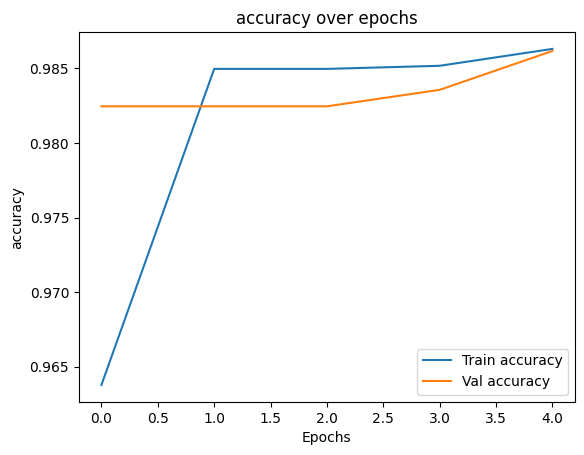

In [44]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
    plt.title(f'{metric} over epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

# Graficar Accuracy, Sensitivity y Specificity
plot_metrics(history, 'accuracy')


## Visualización de Resultados con Predicciones 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


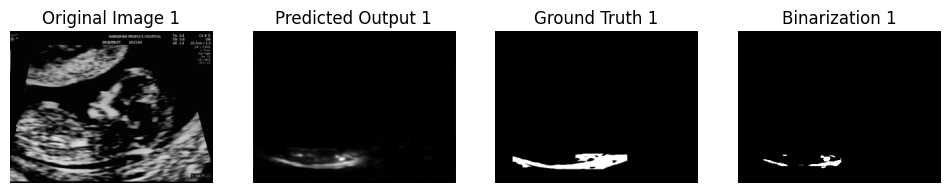

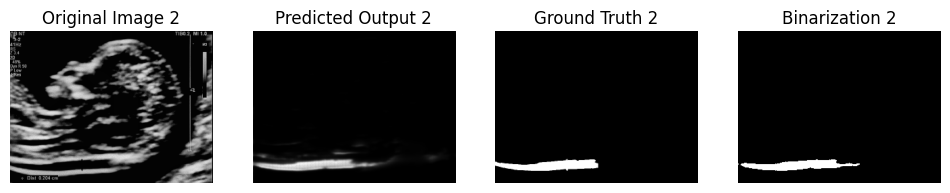

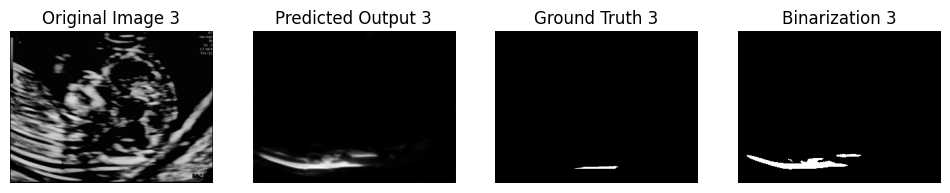

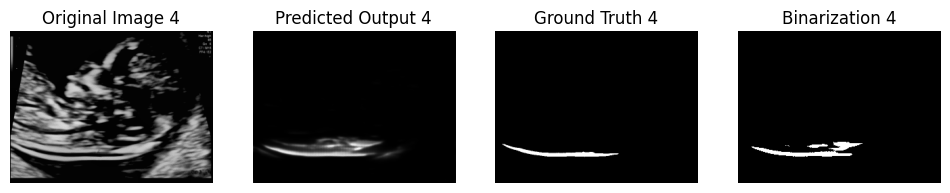

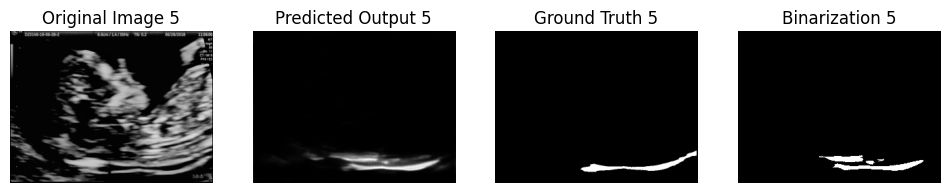

In [87]:
y_pred = model.predict(X_val[:5])  # Predict on the first 5 validation images

# Create a plot to compare original, predicted, and validation images
for i in range(5):  # Show the first 5 images
    plt.figure(figsize=(12, 4))

    # Original image (input image to the model)
    plt.subplot(1, 4, 1)
    plt.imshow(X_val[i])
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    # Predicted output (the model's output)
    plt.subplot(1, 4, 2)
    plt.imshow(y_pred[i], cmap='gray')  # Use grayscale for segmentation maps
    plt.title(f"Predicted Output {i+1}")
    plt.axis('off')

    # Validation image (ground truth mask)
    plt.subplot(1, 4, 3)
    plt.imshow(y_val[i], cmap='gray')
    plt.title(f"Ground Truth {i+1}")
    plt.axis('off')

    # Binarization of the output image 
    y_bin = y_pred[i] > 0.3 
    plt.subplot(1, 4, 4)
    plt.imshow(y_bin, cmap='gray')
    plt.title(f"Binarization {i+1}")
    plt.axis('off')


    

    # Display the plot
    plt.show()

Se presenta la imágen original con la predicción del modelo. A su vez, luego se compara Ground Truth que se obtuvo en etapas previas para entrenar al modelo con la salida del modelo binarizada mediante un umbral.

In [92]:
X_val[0].shape

(225, 300, 3)

In [90]:
y_pred[0].shape

(225, 300, 1)

In [91]:
y_bin.shape

(225, 300, 1)

Se realiza la comparación de la superposición de la imagen original con la Ground Truth y con la salida binarizada del modelo 

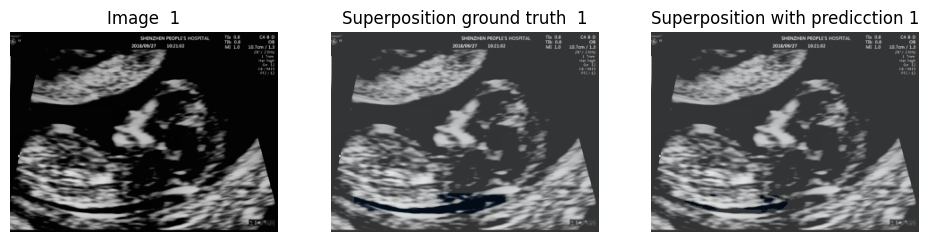

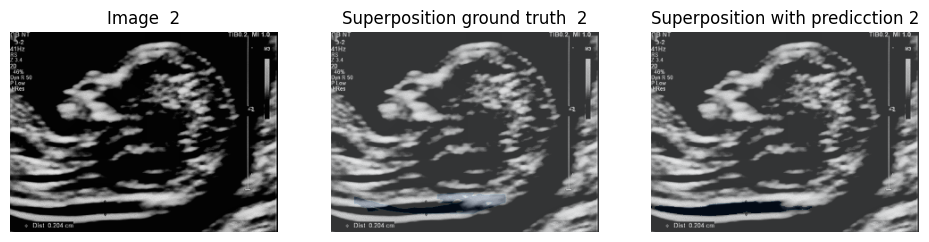

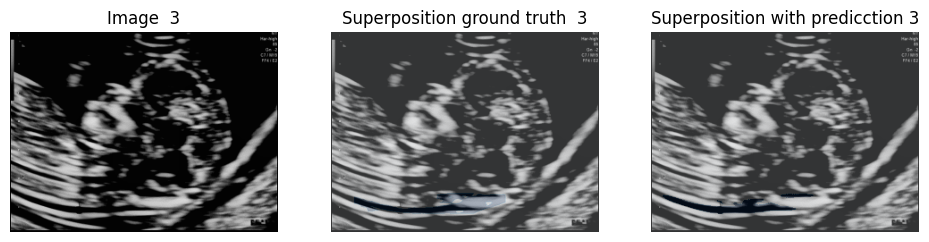

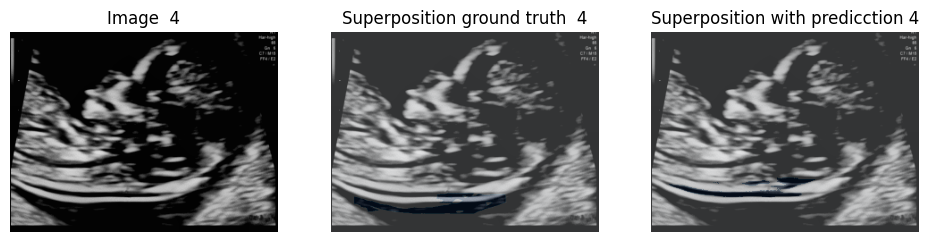

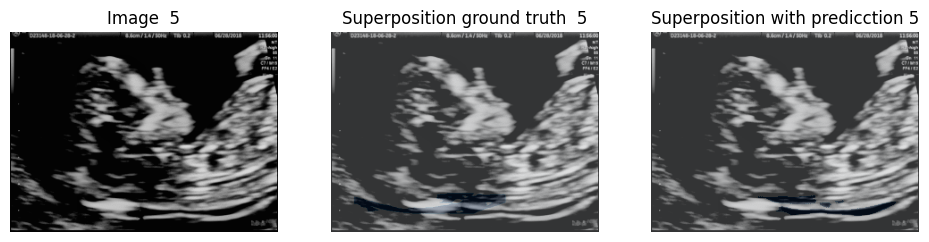

In [94]:
for i in range(5):  # Show the first 5 images
    plt.figure(figsize=(20, 6))

    # Original image

    plt.subplot(1, 5, 1)
    plt.imshow(X_val[i, :, :, :], cmap='gray' )
    plt.title(f"Image  {i+1}")
    plt.axis('off')

    # Original image with ground truth 
    plt.subplot(1, 5, 2)
    plt.imshow(X_val[i, :, :, :], cmap='gray')
    plt.imshow(y_val[0, :, :], alpha=0.2, cmap='Blues')
    plt.title(f"Superposition ground truth  {i+1}")
    plt.axis('off')

    # original image with prediccion 
    plt.subplot(1, 5, 3)
    plt.imshow(X_val[i, :, :, :],  cmap='gray')
    y_bin = y_pred[i] > 0.3 
    plt.imshow(y_bin, alpha=0.2, cmap='Blues')
    plt.title(f"Superposition with predicction {i+1}")
    plt.axis('off')
    
    # Display the plot
    plt.show()

## Conclusiones de la segmentación

Los resultados obtenidos han sido satisfactorios, teniendo en cuenta que las segmentaciones para el entrenamiento de la U-Net fueron creadas mediante un algoritmo propio que las realizaba de manera conjunta. Es decir, no se realizo una segmentación individual. Debido a ello es interezante como las predicciones del modelo en ocaciones superan a la Ground Truth, como en la imagen 2 donde la primera no se ajustaba a la TN por completo mientras que la predicción si. Sin embargo hay ocaciones donde el modelo no es perfecto como con la imagen 1 y se cometen errores. Es clave destacar que en la gran mayoría de casos la predicción supera a la Ground Truth como segmentación, ya que la última al haberse conseguido por un algoritmo de segmentación genérico no es perfecta.